# Classifying Wheat Kernels by Physical Property

In the workshop for this week, you are to select a data set from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html) and based on the recommended analysis type, wrangle the data into a fitted model, showing some model evaluation. In particular:

- Layout the data into a dataset X and targets y.
- Choose regression, classification, or clustering and build the best model you can from it. 
- Report an evaluation of the model built
- Visualize aspects of your model (optional)
- Compare and contrast different model families

When complete, I will review your code, so please submit your code via pull-request to the [Introduction to Machine Learning with Scikit-Learn](https://github.com/georgetown-analytics/machine-learning) repository!

## Wheat Kernel Example

Downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/seeds) on February 26, 2015. The first thing is to fully describe your data in a README file. The dataset description is as follows:

- Data Set: Multivariate
- Attribute: Real
- Tasks: Classification, Clustering
- Instances: 210
- Attributes: 7

### Data Set Information:

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

The data set can be used for the tasks of classification and cluster analysis.

### Attribute Information:

To construct the data, seven geometric parameters of wheat kernels were measured:

1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

All of these parameters were real-valued continuous.

### Relevant Papers:

M. Charytanowicz, J. Niewczas, P. Kulczycki, P.A. Kowalski, S. Lukasik, S. Zak, 'A Complete Gradient Clustering Algorithm for Features Analysis of X-ray Images', in: Information Technologies in Biomedicine, Ewa Pietka, Jacek Kawa (eds.), Springer-Verlag, Berlin-Heidelberg, 2010, pp. 15-24.

## Data Exploration 

In this section we will begin to explore the dataset to determine relevant information.

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"

def fetch_data(fname='seeds_dataset.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [3]:
FEATURES  = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry",
    "groove",
    "label"
]

LABEL_MAP = {
    1: "Kama",
    2: "Rosa",
    3: "Canadian",
}

# Read the data into a DataFrame
df = pd.read_csv(DATA, sep='\s+', header=None, names=FEATURES)

# Convert class labels into text
for k,v in LABEL_MAP.items():
    df.ix[df.label == k, 'label'] = v

# Describe the dataset
print(df.describe())

             area   perimeter  compactness      length       width  \
count  210.000000  210.000000   210.000000  210.000000  210.000000   
mean    14.847524   14.559286     0.870999    5.628533    3.258605   
std      2.909699    1.305959     0.023629    0.443063    0.377714   
min     10.590000   12.410000     0.808100    4.899000    2.630000   
25%     12.270000   13.450000     0.856900    5.262250    2.944000   
50%     14.355000   14.320000     0.873450    5.523500    3.237000   
75%     17.305000   15.715000     0.887775    5.979750    3.561750   
max     21.180000   17.250000     0.918300    6.675000    4.033000   

        asymmetry      groove  
count  210.000000  210.000000  
mean     3.700201    5.408071  
std      1.503557    0.491480  
min      0.765100    4.519000  
25%      2.561500    5.045000  
50%      3.599000    5.223000  
75%      4.768750    5.877000  
max      8.456000    6.550000  


In [4]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(df.groupby('label')['label'].count())

210 instances with 8 features

label
Canadian    70
Kama        70
Rosa        70
Name: label, dtype: int64


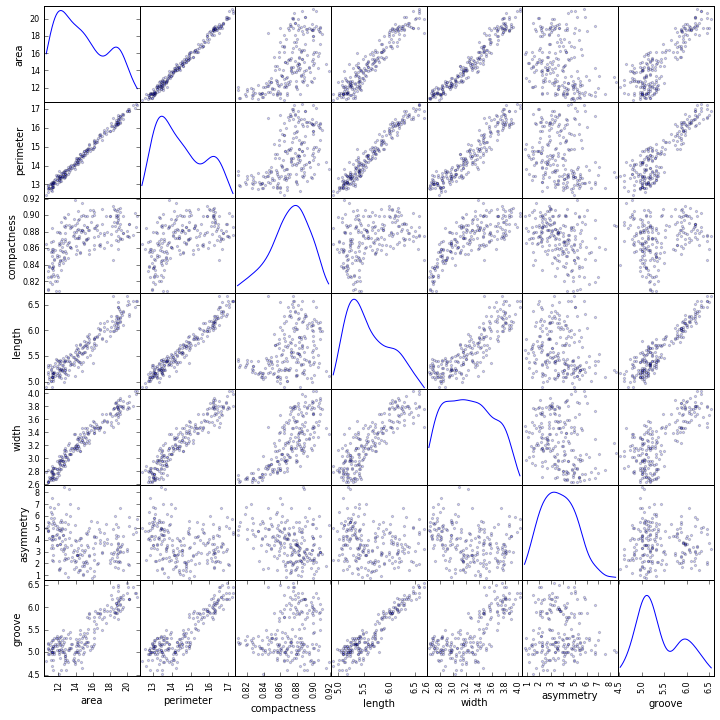

In [5]:
# Create a scatter matrix of the dataframe features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

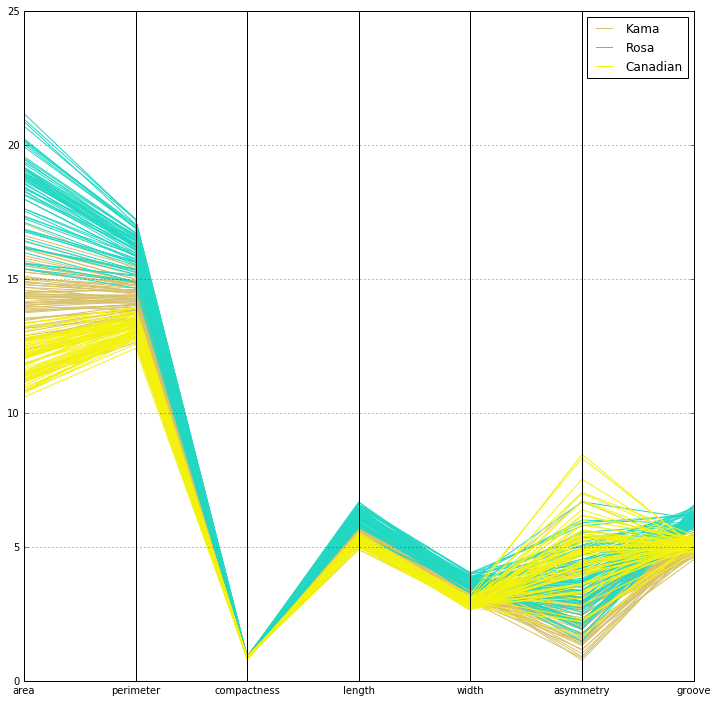

In [6]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(12,12))
parallel_coordinates(df, 'label')
plt.show()

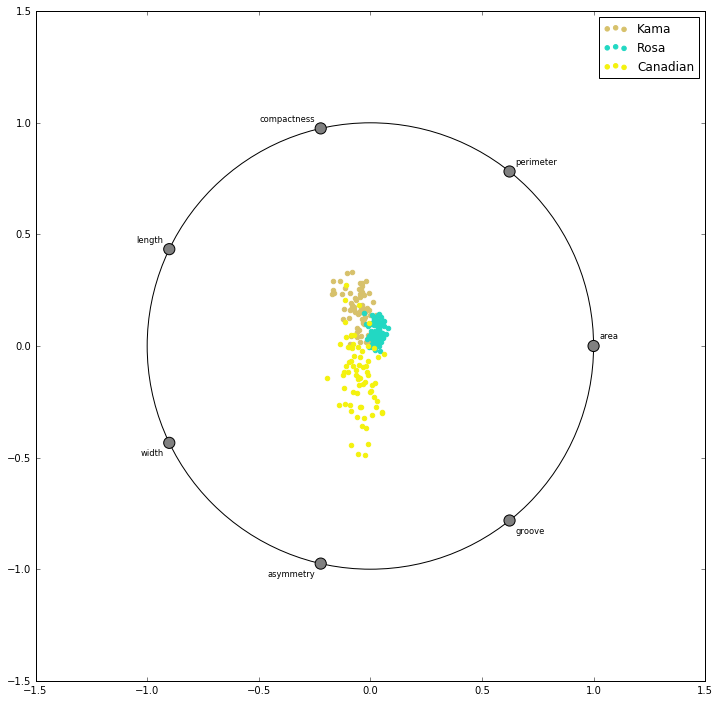

In [7]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(12,12))
radviz(df, 'label')
plt.show()

## Data Extraction 

One way that we can structure our data for easy management is to save files on disk. The Scikit-Learn datasets are already structured this way, and when loaded into a `Bunch` (a class imported from the `datasets` module of Scikit-Learn) we can expose a data API that is very familiar to how we've trained on our toy datasets in the past. A `Bunch` object exposes some important properties:

- **data**: array of shape `n_samples` * `n_features`
- **target**: array of length `n_samples`
- **feature_names**: names of the features
- **target_names**: names of the targets
- **filenames**: names of the files that were loaded
- **DESCR**: contents of the readme

**Note**: This does not preclude database storage of the data, in fact - a database can be easily extended to load the same `Bunch` API. Simply store the README and features in a dataset description table and load it from there. The filenames property will be redundant, but you could store a SQL statement that shows the data load. 

In order to manage our data set _on disk_, we'll structure our data as follows:

In [8]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..", "data", "wheat"))

# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print("- {}".format(name))

- dataset.csv
- meta.json
- README.md
- seeds_dataset.txt
- wrangle.py


In [9]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the wheat dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'seeds_dataset.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'])

    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(210, 7)
(210,)


## Classification 

Now that we have a dataset `Bunch` loaded and ready, we can begin the classification process. Let's attempt to build a classifier with kNN, SVM, and Random Forest classifiers. 

In [10]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [11]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [12]:
# Perform SVC Classification
fit_and_evaluate(dataset, SVC, "Wheat SVM Classifier")

Build and Validation of Wheat SVM Classifier took 0.028 seconds
Validation scores are as follows:

accuracy     0.900871
f1           0.899559
precision    0.915584
recall       0.900871
dtype: float64

Fitted model written to:
/Users/nicole/Documents/school/gtown/TA/machine-learning/notebook/wheat-svm-classifier.pickle


In [13]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Wheat kNN Classifier", n_neighbors=12)

Build and Validation of Wheat kNN Classifier took 0.025 seconds
Validation scores are as follows:

accuracy     0.904412
f1           0.905731
precision    0.919768
recall       0.904412
dtype: float64

Fitted model written to:
/Users/nicole/Documents/school/gtown/TA/machine-learning/notebook/wheat-knn-classifier.pickle


In [14]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Wheat Random Forest Classifier")

Build and Validation of Wheat Random Forest Classifier took 0.218 seconds
Validation scores are as follows:

accuracy     0.909858
f1           0.911721
precision    0.925655
recall       0.909858
dtype: float64

Fitted model written to:
/Users/nicole/Documents/school/gtown/TA/machine-learning/notebook/wheat-random-forest-classifier.pickle
